In [1]:
import os, sys
import pathlib
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Audio read

In [4]:
MAC_FFMPEG_BIN_PATH = pathlib.Path("./ffmpeg-4.1.4-macos64-static/bin/")
WIN_FFMPEG_BIN_PATH = pathlib.Path("./ffmpeg-4.1.4-win64-static/bin/")

if sys.platform == "darwin":
    ffmpeg_bin_path = MAC_FFMPEG_BIN_PATH
elif sys.platform == 'win32':
    ffmpeg_bin_path = WIN_FFMPEG_BIN_PATH
else:
    print("This platform is not supported.")
    
def get_os_exec_path(executable_name, ffmepg_bin_path):
    return ffmpeg_bin_path / (executable_name + (".exe" if sys.platform == 'win32' else ''))

In [5]:
def get_audio_info(audio_path, ffmpeg_bin_path):
    ffprobe_path = get_os_exec_path("ffprobe", ffmpeg_bin_path)
    cmd = "{exec} -i {input} -hide_banner".format(exec=ffprobe_path, input=audio_path)
    completed_process = subprocess.run(cmd.split(), capture_output=True)
    info = completed_process.stderr.decode()
    return info

def get_audio_stream_metadata(audio_path, key, ffmpeg_bin_path, pretty=False, count_frames=True):
    available_keys = ["duration_ts", "sample_rate", "bit_rate", "nb_frames", "nb_read_frames"]
    ffprobe_path = get_os_exec_path("ffprobe", ffmpeg_bin_path)
    cmd = "{exec} -v error {count_frames}-show_entries stream={key} -of default=noprint_wrappers=1:nokey=1 {pretty}{input}".format(exec = ffprobe_path, 
          key = key, count_frames = "-count_frames " if count_frames else '', pretty = "-pretty " if pretty else '', input = audio_path)
    completed_process = subprocess.run(cmd.split(), capture_output=True)
    duration = completed_process.stdout.decode().rstrip()
    return duration

In [6]:
def get_total_second(datetime):
    return datetime.hour * 3600 + datetime.minute * 60 + datetime.second + (datetime.microsecond / 10**6)

In [7]:
def get_buffer_size_from_duration(duration_string, sampling_rate, offset=500, duration_format="sexagesimal"):
    if duration_format == "sexagesimal":
        dtime = datetime.strptime(duration, "%H:%M:%S.%f")
        duration_second = dtime.minute * 60 + dtime.second + (dtime.microsecond / 10**6)
    elif duration_format == "second":
        duration_second = float(duration_string)
    sample_number = duration_second * sampling_rate + offset
    buffer_size = int(sample_number) * 2
    return buffer_size

In [8]:
def conversion_time_interval_to_frame_interval(start_time, end_time):
    start_dtime = datetime.strptime(start_time, "%M:%S.%f")
    end_dtime = datetime.strptime(end_time, "%M:%S.%f")
    start_sample = int(get_total_second(start_dtime) * 44100)
    end_sample = int(get_total_second(end_dtime) * 44100)
    return [start_sample, end_sample]

In [9]:
def grep_time_interval_from_audio(audio, start_time, end_time):
    start_sample, end_sample = conversion_time_interval_to_frame_interval(start_time, end_time)
    return audio[start_sample:end_sample]

In [10]:
def load_audio(audio_path, buffer_size, ffmpeg_bin_path):
    command = "{ffmpeg} -i {audio_file} -f {format} -ar 44100 -ac 1 -".format(ffmpeg=get_os_exec_path("ffmpeg", ffmpeg_bin_path), 
                                                                              audio_file=audio_path,
                                                                              format='s16le')
    pipe = subprocess.Popen(command.split(), stdout=subprocess.PIPE, stderr=open(os.devnull, 'w'), 
                            bufsize=buffer_size)
    raw = pipe.stdout.read(buffer_size)
    audio = np.frombuffer(raw, dtype=np.int16)
    return audio

In [11]:
audio_path = pathlib.Path("Audio/190716/Voix_190716.3gp")

info = get_audio_info(audio_path, ffmpeg_bin_path)
duration = get_audio_stream_metadata(audio_path, "duration", ffmpeg_bin_path, pretty=True)

real_nb_samples = int(get_audio_stream_metadata(audio_path, "duration_ts", ffmpeg_bin_path, pretty=True, count_frames=True))
nb_frames = int(get_audio_stream_metadata(audio_path, "nb_read_frames", ffmpeg_bin_path, pretty=True, count_frames=True))
nb_samples = nb_frames * 1024 # The number of frames per packet is set to 1024 for the AAC codec, manual checked with 'ffmpeg.exe -v error -show_frames input.x'
buffer_size = nb_samples * 2

audio = load_audio(audio_path, buffer_size, ffmpeg_bin_path)
print("Audio size = {}".format(audio.size))

Audio size = 5388288


In [12]:
# Noise Reduction parameters:
# Noise section : 01m45.000s -> 01m47.950s
# Level = 48 dB, Sensitivity = 7.00, Frequency smoothing = 1

In [13]:
audio_path_NR = pathlib.Path("Audio/190716/Voix_190716_NR.3gp")

info_NR = get_audio_info(audio_path_NR, ffmpeg_bin_path)
duration_NR = get_audio_stream_metadata(audio_path_NR, "duration", ffmpeg_bin_path, pretty=True)

real_nb_samples_NR = int(get_audio_stream_metadata(audio_path_NR, "duration_ts", ffmpeg_bin_path, pretty=True, count_frames=True))
nb_frames_NR = int(get_audio_stream_metadata(audio_path_NR, "nb_read_frames", ffmpeg_bin_path, pretty=True, count_frames=True))
nb_samples_NR = nb_frames_NR * 1024 # The number of frames per packet is set to 1024 for the AAC codec, manual checked with 'ffmpeg.exe -v error -show_frames input.x'
buffer_size_NR = nb_samples_NR * 2

audio_NR = load_audio(audio_path_NR, buffer_size_NR, ffmpeg_bin_path)
print("Audio size = {}".format(audio_NR.size))

Audio size = 5389312


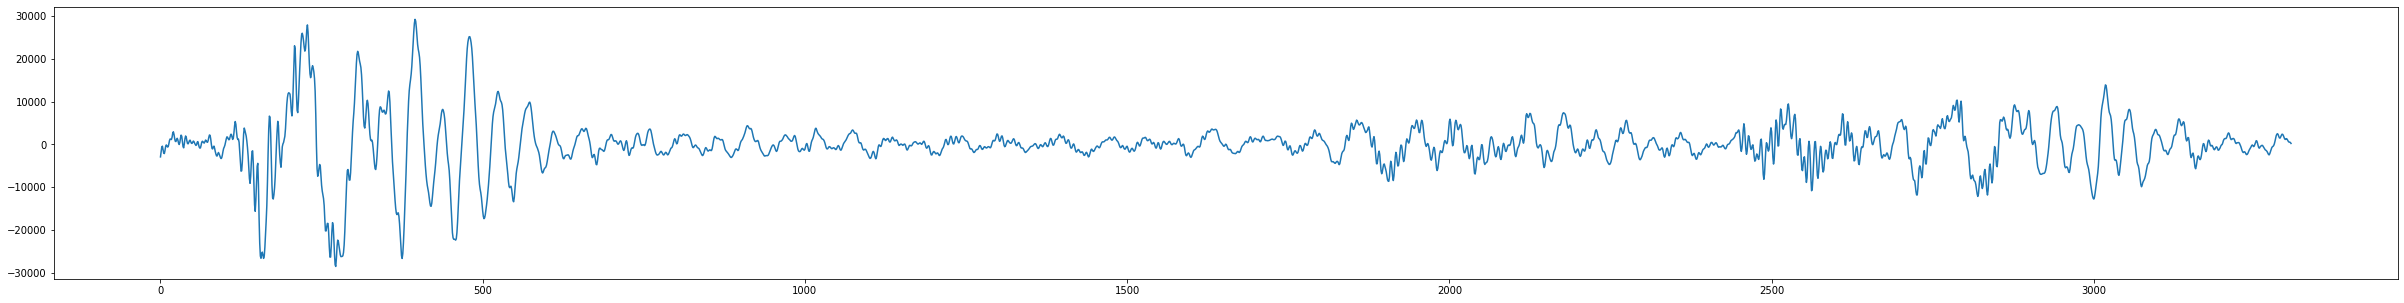

In [14]:
samples = grep_time_interval_from_audio(audio, '1:33.530', '1:33.605')
plt.plot(samples)
plt.xlim = 0
fig = plt.gcf()
fig.set_size_inches(42,5)

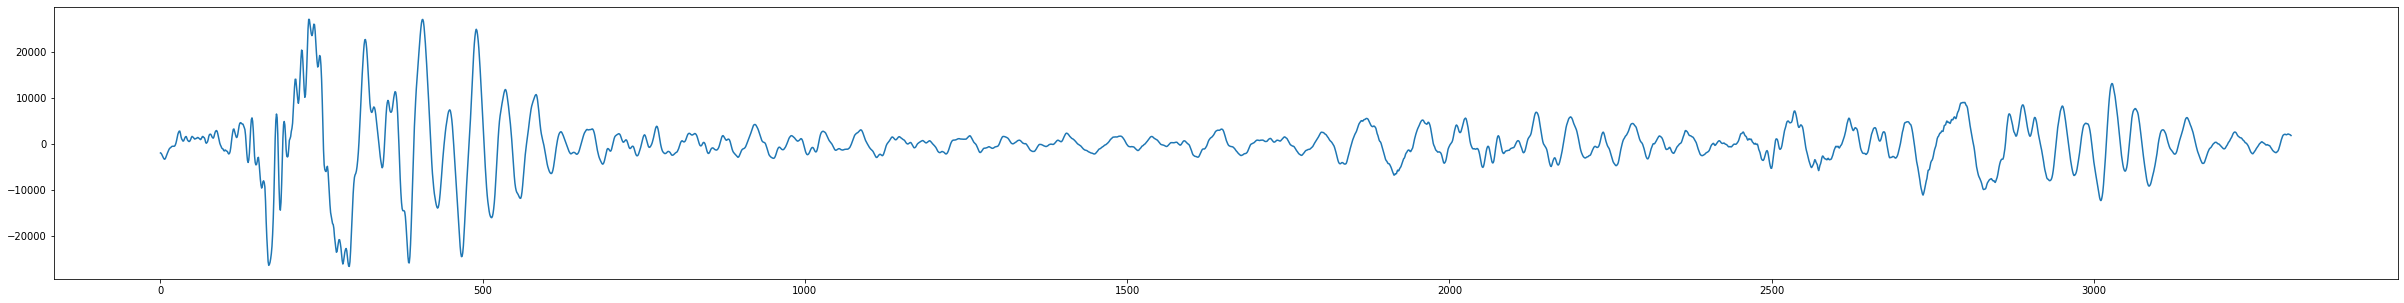

In [15]:
samples_NR = grep_time_interval_from_audio(audio_NR, '1:33.553', '1:33.628')
plt.plot(samples_NR)
plt.xlim = 0
fig = plt.gcf()
fig.set_size_inches(42,5)

In [16]:
print(info)

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'Audio/190716/Voix_190716.3gp':
  Metadata:
    major_brand     : 3gp4
    minor_version   : 0
    compatible_brands: isom3gp4
    creation_time   : 2019-07-16T23:51:31.000000Z
    com.android.version: 7.0
  Duration: 00:02:02.18, start: 0.000000, bitrate: 122 kb/s
    Stream #0:0(eng): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, mono, fltp, 96 kb/s (default)
    Metadata:
      creation_time   : 2019-07-16T23:51:31.000000Z
      handler_name    : SoundHandle



In [17]:
print(info_NR)

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'Audio/190716/Voix_190716_NR.3gp':
  Metadata:
    major_brand     : 3gp4
    minor_version   : 512
    compatible_brands: isomiso23gp4
  Duration: 00:02:02.21, start: 0.000000, bitrate: 111 kb/s
    Stream #0:0(und): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, mono, fltp, 110 kb/s (default)
    Metadata:
      handler_name    : SoundHandler



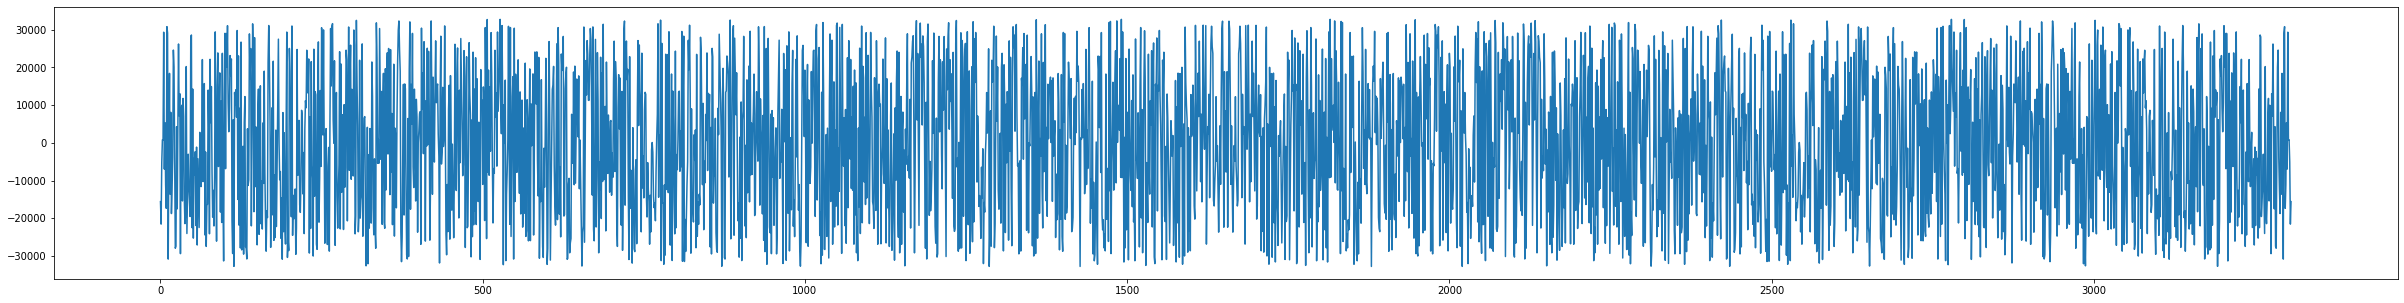

In [18]:
auto_corr = np.correlate(samples_NR, samples_NR, mode='same')
auto_corr_2 = auto_corr[auto_corr.size//2:]
plt.plot(auto_corr)
plt.xlim = 0
fig = plt.gcf()
fig.set_size_inches(42,5)

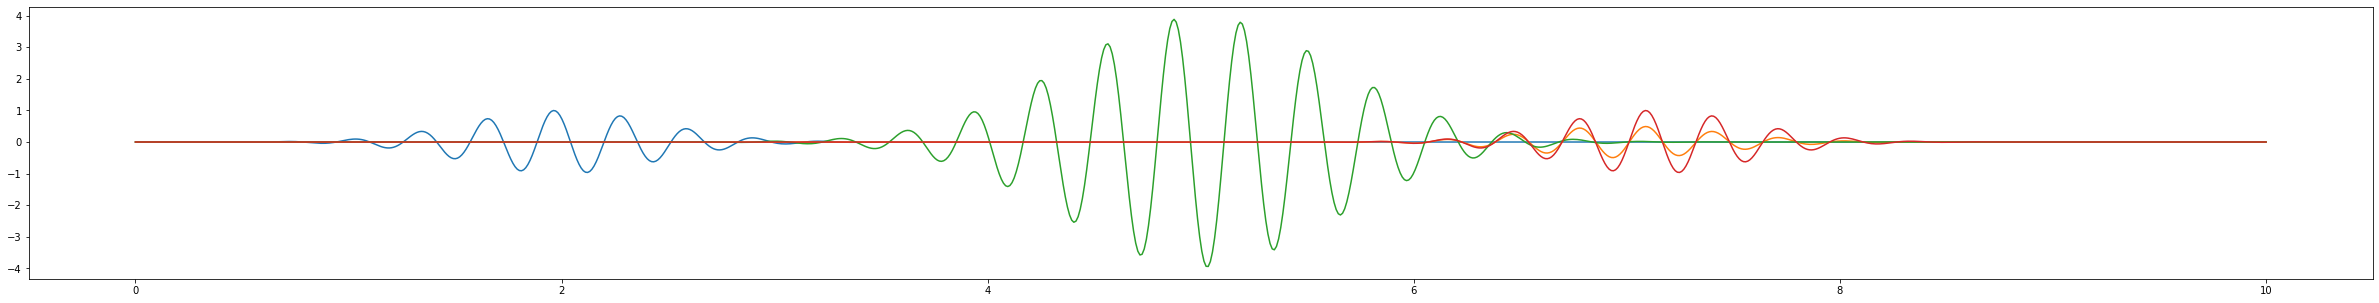

In [19]:
x = np.linspace(0,10,1000)
s_1 = np.exp(-(x-2)**2/0.4)*np.sin(20*x)
s_2 = 0.5*np.exp(-(x-7)**2/0.4)*np.sin(20*x-2)
s_3 = np.sin(20*x)
c = 0.2*np.correlate(s_1, s_2, mode='full')
x_m = x[c.argmax()]
x_m = 5.125
s_4 = np.exp(-((x-x_m)-2)**2/0.4)*np.sin(20*(x-x_m))
# plt.plot(x,s_1,x,s_2,x,s_3)

plt.plot(x,s_1,x,s_2,x,c[:c.size//2+1],x,s_4)
# plt.plot(x,s_1,x,s_2,x,s_4)
fig = plt.gcf()
fig.set_size_inches(42,5)

In [20]:
x[c.argmin()+8]

5.115115115115115

## Analysis

In [21]:
sound_speed = 340.29

In [22]:
96000/2

48000.0

In [23]:
def convert_ft_to_m(feets):
    return feets * 0.3048

In [24]:
def pixel_distance(l, h):
    return np.sqrt(l**2 + h**2)

In [25]:
#double echo time delay
d_1 = 8
d_2 = 11.70
print("First Echo after : {:.5}s".format(2 * (d_1 / sound_speed)))
print("First Echo after : {:.5}s".format(2 * (d_2 / sound_speed)))

First Echo after : 0.047019s
First Echo after : 0.068765s


In [26]:
(0.069*sound_speed)/2 - (0.068*sound_speed)/2

0.17014499999999977

In [27]:
def v(d, t):
    return d/t

def convert_ms_to_kmh(v):
    return v * 3.6

In [28]:
def compute_ajusted_speed(d, t, d_t=1.0, d_w=11.70, h=2.4, sound_speed=340.29):
    d_t_w = np.sqrt(d_w**2 + d_t**2)
    d_t_p = np.sqrt(h**2 + d_t**2)
    hit_delay = d_t_p / sound_speed
    wall_delay = d_t_w / sound_speed
    adjusted_time = t - wall_delay + hit_delay
    v_ms = d / adjusted_time
    return v_ms * 3.6

In [29]:
compute_ajusted_speed(11.71,0.389)

116.4103502542679

In [30]:
compute_ajusted_speed(11.71,0.320) #190724_7 start=46.300s

143.811977094556

In [31]:
compute_ajusted_speed(11.71,0.317) #190724_10 start=41.303s

145.29900651361362

In [32]:
compute_ajusted_speed(11.71,0.304) #190724_11 start=14.631s

152.11482709149075

In [33]:
compute_ajusted_speed(11.71,0.306) #190724_11 start=29.536s

151.02491680087152

In [34]:
compute_ajusted_speed(11.71,0.314) #190724_11 start=1m31.571s

146.81710928318716

In [35]:
from scipy.fftpack import fft

In [36]:
audio_file = pathlib.Path("Audio/190724/Voix_190724_11.3gp")

info = get_audio_info(audio_file, ffmpeg_bin_path)
duration = get_audio_stream_metadata(audio_file, "duration", ffmpeg_bin_path, pretty=True)

real_nb_samples = int(get_audio_stream_metadata(audio_file, "duration_ts", ffmpeg_bin_path, pretty=True, count_frames=True))
nb_frames = int(get_audio_stream_metadata(audio_file, "nb_read_frames", ffmpeg_bin_path, pretty=True, count_frames=True))
nb_samples = nb_frames * 1024 # The number of frames per packet is set to 1024 for the AAC codec, manual checked with 'ffmpeg.exe -v error -show_frames input.x'
buffer_size = nb_samples * 2

audio = load_audio(audio_file, buffer_size, ffmpeg_bin_path)
print("Audio size = {}".format(audio.size))

Audio size = 5781504


In [37]:
nb_frames * 102

575892

In [38]:
print(info)

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'Audio/190724/Voix_190724_11.3gp':
  Metadata:
    major_brand     : 3gp4
    minor_version   : 0
    compatible_brands: isom3gp4
    creation_time   : 2019-07-25T01:24:33.000000Z
    com.android.version: 7.0
  Duration: 00:02:11.10, start: 0.000000, bitrate: 120 kb/s
    Stream #0:0(eng): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, mono, fltp, 96 kb/s (default)
    Metadata:
      creation_time   : 2019-07-25T01:24:33.000000Z
      handler_name    : SoundHandle



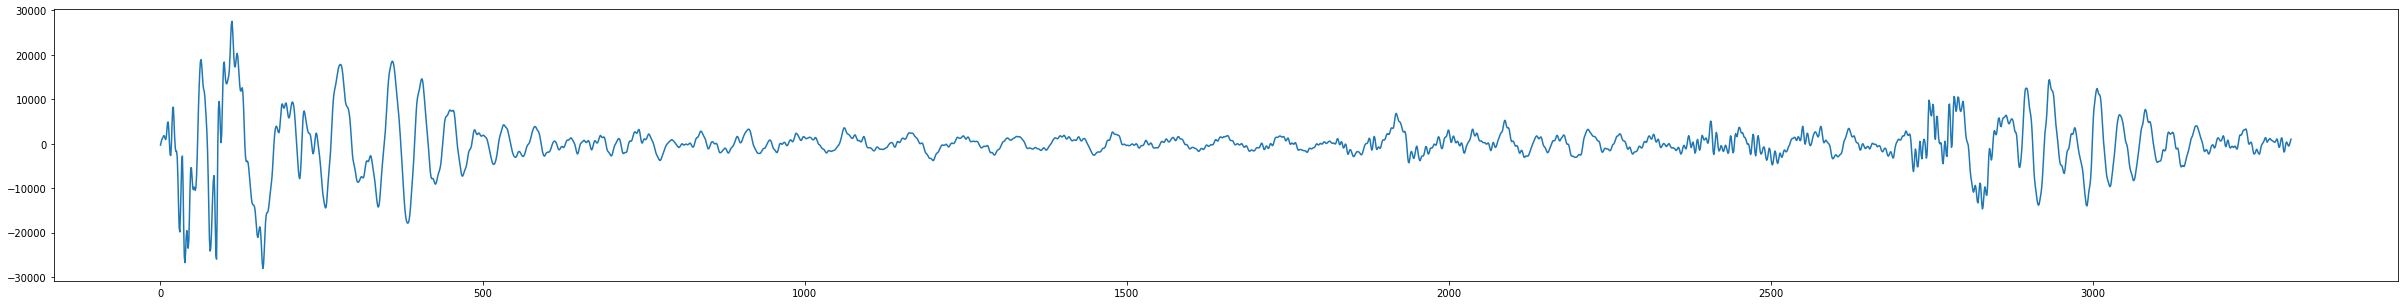

In [54]:
audio = grep_time_interval_from_audio(audio, "1:31.570", "1:31.645")
plt.plot(audio)
fig = plt.gcf()
fig.set_size_inches(42,5)

In [89]:
p = figure(plot_height=700, plot_width=2200)
x = np.arange(audio.size)
audio_s = shift(audio, 2685, fill_value=0)
s1 = p.line(x, audio, line_width=2, color="blue")
s2 = p.line(x, audio_s, line_width=2, color="red")
p.xaxis[0].formatter.use_scientific = False
show(p)

In [83]:
2641/44100

0.05988662131519274

In [60]:
def shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [62]:
shift(np.arange(10), 3, fill_value=0)

array([0, 0, 0, 0, 1, 2, 3, 4, 5, 6])

In [42]:
#Bon echos:
#190724_11 -> t = 44.490s
#190724_11 -> t = 1.31.570s
#190724_11 -> t = 1.41.807s
#190724_11 -> t = 1.49.656s

In [43]:
d1_p = pixel_distance(2171, 14)
d1_r = 5.4864
d2_p = pixel_distance(4633, 33)
d = (d2_p * d1_r) / d1_p

In [44]:
d

11.708248493011181

In [45]:
(2.3 / 340.29)

0.006758940903347144

In [46]:
"{:.7f}".format(1/44100)

'0.0000227'